In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [33]:
import mlp_mixer_pytorch
import mlp_shaker_flat

In [4]:
torch.manual_seed(0)
np.random.seed(0)
M1 = torch.randn(100, 100)
M2 = torch.randn(100, 100)
M3 = torch.randn(100, 100)

X_train = torch.randn(9999, 100)
Y_train = (X_train@M
X_test = torch.randn(9999, 100)
Y_test = X_test@M

In [97]:
def evaluate(net, train='False', device=None, bs=300, verbose=False):
    net = net.to(device)
    losses = []
    if train:
        X, Y = X_train, Y_train
    else:
        X, Y = X_test, Y_test
#     for X_batch, Y_batch in tqdm(zip(X.split(bs), Y.split(bs)), leave=False, total=math.ceil(len(X)/bs)):
    for X_batch, Y_batch in zip(X.split(bs), Y.split(bs)):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_batch_pred = net(X_batch)
        loss = (Y_batch_pred-Y_batch).pow(2.).mean().item()
        losses.append(loss)
    losses = np.mean(losses)
    if verbose:
        print(f'Average Loss: {losses}')
    return {'loss': losses}
    
def train(net, lr=1e-2, device=None, n_epochs=10, bs=300):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    losses_train, losses_test = [], []
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
#         for X_batch, Y_batch in tqdm(zip(X_train.split(bs), Y_train.split(bs)), leave=False, total=math.ceil(len(X_train)/bs)):
        for X_batch, Y_batch in zip(X_train.split(bs), Y_train.split(bs)):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)
            loss = (Y_batch_pred-Y_batch).pow(2.).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
        losses_train.append(evaluate(net, train=True, bs=bs, device=device)['loss'])
        losses_test.append(evaluate(net, train=False, bs=bs, device=device)['loss'])
        loop.set_postfix({'loss': losses_train[-1]})
    plt.plot(losses_train, label='training loss')
    plt.plot(losses_test, label='training loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()

# params:  10100


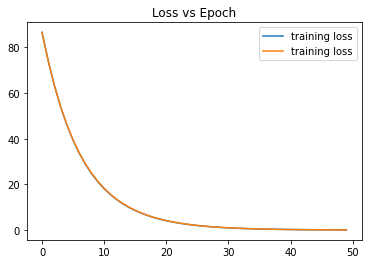

In [121]:
net = nn.Linear(100, 100)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=50)

# params:  20400


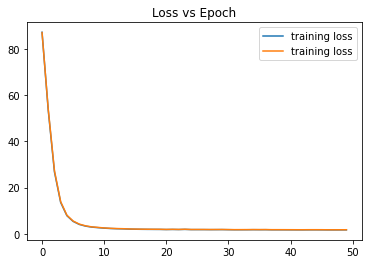

In [117]:
net = mlp_shaker_flat.MLPFlatShaker([100], [0], )
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=50)

# params:  2400


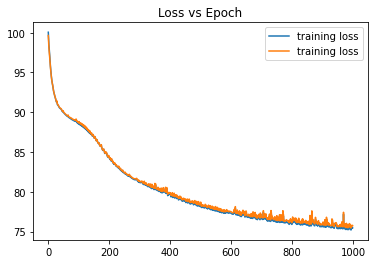

In [113]:
net = mlp_shaker_flat.MLPFlatShaker([10, 10], [0, 1]*5, ).to(device)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=1000)

# params:  26080


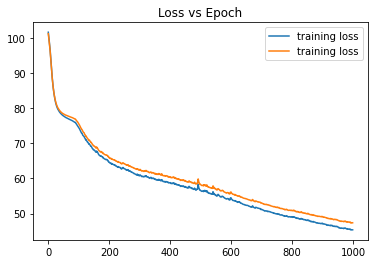

In [120]:
net = mlp_shaker_flat.MLPFlatShaker([50, 2], [0, 1]*5, ).to(device)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-3, bs=1000, n_epochs=1000)